In [ ]:
from pathlib import Path
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from schedulefree import AdamWScheduleFree
from tqdm.auto import tqdm
from fastprogress import master_bar, progress_bar


In [ ]:
path = kagglehub.dataset_download("vsevolodbogodist/data-jokes")
path = Path(path)

In [ ]:
data = pd.read_csv(path / 'dataset.csv')
data.head()

In [ ]:
data.shape

(150553, 1)

In [ ]:
data.text = data.text + '<end>'

In [ ]:
if Path("tokenizer.json").exists():
    tokenizer = Tokenizer.from_file("tokenizer.json")
else:    
    tokenizer = Tokenizer(BPE())
    trainer = BpeTrainer(vocab_size=100, special_tokens=["<end>"])
    tokenizer.train_from_iterator(data.text, trainer)
    tokenizer.save("tokenizer.json")

In [ ]:
def encode(batch, max_length=128):
    items = [torch.tensor(t.ids[:min(len(t.ids), max_length)]) for t in tokenizer.encode_batch_fast(batch)]
    return torch.nn.utils.rnn.pad_sequence(items, batch_first=True)


def get_xy(x: torch.Tensor):
    return x[:, :-1], x[:, 1:]

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [ ]:
model_d = 256
embed_size = 16

In [ ]:
n_vocab = tokenizer.get_vocab_size()

# since pickle can't work with lambdas
def f(x): return x[0]
model = nn.Sequential(
    nn.Embedding(n_vocab, embed_size),
    nn.LSTM(
        input_size=embed_size,
        hidden_size=model_d,
        num_layers=2,
        batch_first=True,
        dropout=0.2),
    Lambda(f),
    nn.Dropout(0.2),
    nn.Linear(model_d, n_vocab),
)

In [ ]:
loader = DataLoader(data.text, batch_size=64)

In [ ]:
from fastprogress import progress_bar, master_bar


def plot_loss_update(step, total_steps, mb, train_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, step + 1)
    y = train_loss
    graphs = [[x, train_loss],]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1 - x_margin, min(total_steps, step) + x_margin]
    y_bounds = [np.min(y) - y_margin, np.max(y) + y_margin]
    mb.update_graph(graphs, x_bounds, y_bounds)

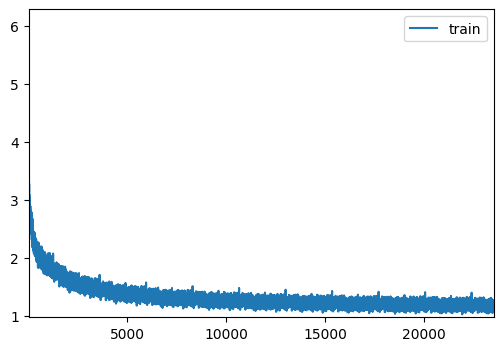

In [ ]:
n_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.cuda()
device = torch.device("cuda")

mb = master_bar(range(n_epochs))
total_steps = len(loader) * n_epochs
step, losses = 1, []
for epoch in mb:
    model.train()
    if hasattr(optimizer, 'train'): optimizer.train()
    for xb in progress_bar(loader, parent=mb):
        xb, yb = get_xy(encode(xb).to(device))
        y_pred = model(xb)
        loss = F.cross_entropy(y_pred.view(-1, n_vocab), yb.to(device).flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        mb.child.comment = f"loss: {loss.item():.2f}"
        plot_loss_update(step, total_steps, mb, losses)
        step += 1
    # Validation
    model.eval()
    loss = 0
    with torch.no_grad():
        for xb in loader:
            xb, yb = get_xy(encode(xb).to(device))
            y_pred = model(xb)
            loss += F.cross_entropy(y_pred.view(-1, n_vocab), yb.flatten())
        mb.write(f"Epoch {epoch}: Cross-entropy: {loss:.4f}")

In [ ]:
# torch.save(model, "lstm.pth")

In [ ]:
model = torch.load("lstm.pth")

In [ ]:
def decode(seq):
    s = ''
    for el in seq:
        res = tokenizer.decode([el])
        if res == '<end>': break
        s += res
    return s
        


def generate(prefixes: list[str]):
    inp = encode(prefixes).cuda()  # (bs, seq_len)
    for _ in range(100):
        with torch.no_grad():
            logits = model(inp)[:, -1]  # (bs, vocab_size) - last token
            probs = torch.softmax(logits, dim=-1)
            sample = torch.multinomial(probs, num_samples=1).type(torch.long)  # (bs, 1)
            inp = torch.cat((inp, sample), dim=1)

    return [decode(x) for x in inp.tolist()]